In [1]:
import numpy as np
import matplotlib.pyplot as plt
import flpoAgent
import importlib
import random
from scipy.spatial.distance import cdist
import createEnv
from scipy.optimize import Bounds, LinearConstraint, minimize
import supporting_functions
from matplotlib.cm import get_cmap

n_waypoints: 3 
n_agents: 2 
CAT:
[5. 5. 5.]
---------
wp_locations:
[[-6.91674315e+00  4.80099393e+00]
 [ 9.95266300e+02  6.74787868e-01]
 [-9.70850075e+00  1.00837494e+03]] 
mask:
[[0 1 1]
 [1 0 0]
 [1 0 0]] 
dist_mat:
[[1.00000000e+08 1.00219154e+03 1.00357783e+03]
 [1.00219154e+03 1.00000000e+08 1.00000000e+08]
 [1.00357783e+03 1.00000000e+08 1.00000000e+08]] 
wp_weights:
[0.33333333 0.33333333 0.33333333]
---------
agent_weights:
[1. 1.] 
sd_mat:
[[2 1]
 [1 2]] 
eta_arr: 
processing_time:
[[4.70547108 0.         4.04245205]
 [4.10407527 3.97075483 0.        ]] 
speed_lim_mat:
[[5.38401999e-01 7.37812051e+01]
 [2.44292129e-02 7.35107228e+01]] 
sched_mat:
[[ 3.34214276 95.69493363  0.        ]
 [28.3828353   0.         94.42251361]]
reach_mat
filter_wp:
[[1. 1. 1.]
 [1. 1. 1.]]
transport_cost:
[-1.95098355e+08 -1.95098356e+08]
conflict_cost:
[0.09057216 0.09057216 0.09057216]


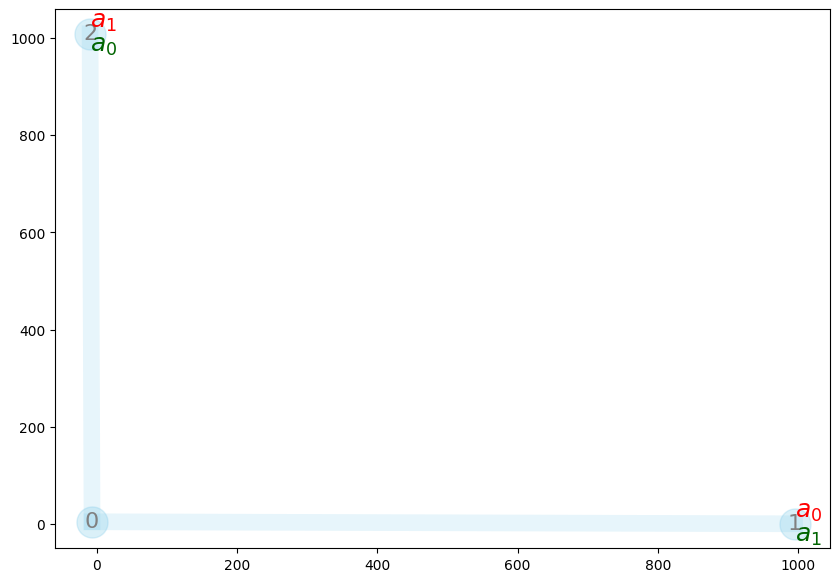

In [2]:
importlib.reload(flpoAgent)
importlib.reload(createEnv)
importlib.reload(supporting_functions)

# generate waypoints and the adjacency matrix
n_waypoints = 3
n_agents = 2
tolArray = np.random.uniform(5.0, 5.0, n_waypoints)

# Grid network parameters
grid_params = {
    'type':'grid',
    'n_points':n_waypoints,
    'grid_size':1000,
    'noise_factor':10
}

# Ring network parameters
ring_params = {
    'type':'ring',
    'num_rings':3,
    'points_per_ring':int(n_waypoints/3),
    'center_distance':200,
    'deformation_level':50.0,
    'extra_connections':0.00,
    'missing_connections':0.05
}

# create a mars environment
mars = createEnv.MARS(
    n_waypoints, 
    n_agents, 
    tolArray, 
    grid_params, 
    seed=12, 
    printFlag=True)

# compute conflict cost
beta0=1e-8
gamma_t = 5
gamma_c = 7.5
coeff_t = 50
coeff_c = 5.0
# calculate conflict cost
# print(f'mars_schedule:\n{np.round(mars.sched_mat,2)}')
# Xi = mars.agents[1].returnStageWiseCost(mars.sched_mat[1,:], mars.dist_mat, gamma_t, coeff_t)
# Pb = mars.agents[1].getPathAssociations(mars.sched_mat[1,:], mars.dist_mat, beta0, gamma_t, coeff_t)
# print(f'agent start:{mars.agents[1].s}\nprobability:\n{Pb[1]}\nstageWiseCost:{Xi[1]}')

reach_mat = mars.calc_agent_reach_mat(
        mars.sched_mat, 
        beta=beta0, gamma=gamma_t, coeff=coeff_t)
filter_wp = np.ones(shape=reach_mat.shape)
filter_wp[reach_mat <= 1.0e-10] = 0.0 
print(f'reach_mat')
print(f'filter_wp:\n{filter_wp}')
mars.transportCost(mars.sched_mat, beta=beta0, gamma=gamma_t, coeff=coeff_t)
print(f'transport_cost:\n{mars.C_agents}')
mars.conflictCost(mars.sched_mat, gamma=gamma_c, coeff=coeff_c, filter_wp=filter_wp)
print(f'conflict_cost:\n{mars.C_wp_conflict}')

# mars visualization
# agent_routes, agent_schedules, agent_colors = createEnv.calc_agent_routes_and_schedules(mars, Pb_a=[], printRoutes=False)
cmap = get_cmap('tab20')
agent_colors = {a: cmap(i / mars.n_agents) for i, a in enumerate(range(mars.n_agents))}
createEnv.plotNetwork(mars=mars, figuresize=(10,7), routes=[], agent_colors=agent_colors, showEdgeLength=False, plotPaths=False)

# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True)



### Write a code to test stagewise cost function calculation based on mean speed of the agents

In [3]:
mars.sched_mat[0,:] = np.array([20, 40, 0.0])

In [4]:
agent_0 = mars.agents[0]
Xi = agent_0.returnStageWiseCost(mars.sched_mat[0,:], mars.dist_mat, gamma=gamma_t, coeff=coeff_t)
agent_0.getFreeEnergy_s(mars.sched_mat[0,:], mars.dist_mat, beta=1e5, gamma=gamma_t, coeff=coeff_t)

40.00002341173004

In [5]:
Xi_1 = agent_0.returnStageWiseCost_v1(mars.sched_mat[0,:], mars.dist_mat)
Grad_Xi = agent_0.returnStagewiseGrad_v1(mars.sched_mat[0,:], mars.dist_mat)

In [6]:
Xi_1

[array([[4.90991859e+01, 9.46902593e+15, 9.46902593e+15]]),
 array([[9.46902593e+15, 4.85777623e+01, 2.20966568e+03],
        [2.20615975e+03, 0.00000000e+00, 9.46902593e+15],
        [4.90991859e+01, 9.46902593e+15, 9.46902593e+15]]),
 array([[9.46902593e+15, 4.85777623e+01, 2.20966568e+03],
        [2.20615975e+03, 0.00000000e+00, 9.46902593e+15],
        [4.90991859e+01, 9.46902593e+15, 9.46902593e+15]]),
 array([[4.85777623e+01],
        [0.00000000e+00],
        [9.46902593e+15]])]

In [7]:
Grad_Xi[1]

array([[[-3.71598036e-07, -1.99629215e+01,  2.00370273e+01],
        [-2.00370785e+01,  0.00000000e+00,  0.00000000e+00],
        [ 1.99629727e+01,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  1.99629215e+01,  0.00000000e+00],
        [ 2.00370785e+01, -3.71598036e-07,  4.00000004e+01],
        [ 0.00000000e+00,  3.99999996e+01,  0.00000000e+00]],

       [[ 0.00000000e+00,  0.00000000e+00, -2.00370273e+01],
        [ 0.00000000e+00,  0.00000000e+00, -4.00000004e+01],
        [-1.99629727e+01, -3.99999996e+01, -3.71598036e-07]]])

In [8]:
Grad_Xi[0]

array([[[ 1.99629727e+01,  0.00000000e+00,  0.00000000e+00]],

       [[ 0.00000000e+00,  3.99999996e+01,  0.00000000e+00]],

       [[-1.99629727e+01, -3.99999996e+01, -3.71598036e-07]]])

In [9]:
Grad_Xi[-1]

array([[[-1.99629215e+01],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 1.99629215e+01],
        [-3.71598036e-07],
        [ 3.99999996e+01]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [-3.99999996e+01]]])

In [10]:
beta1 = 1e-8

In [11]:
Pi_1 = agent_0.getPathAssociations_v1(mars.sched_mat[0,:], mars.dist_mat, beta=beta1)
Pi_1

[array([[1., 0., 0.]]),
 array([[0.        , 0.66666918, 0.33333082],
        [0.33333083, 0.66666917, 0.        ],
        [1.        , 0.        , 0.        ]]),
 array([[0.        , 1.        , 0.        ],
        [0.49999436, 0.50000564, 0.        ],
        [1.        , 0.        , 0.        ]]),
 array([[1.],
        [1.],
        [1.]])]

In [13]:
GV = agent_0.backPropDP_grad(Grad_Xi, Pi_1)

In [16]:
GV[-1]

array([[[-1.99629215e+01],
        [ 0.00000000e+00],
        [ 0.00000000e+00]],

       [[ 1.99629215e+01],
        [-3.71598036e-07],
        [ 3.99999996e+01]],

       [[ 0.00000000e+00],
        [ 0.00000000e+00],
        [-3.99999996e+01]]])

In [6]:
sched0_init = mars.sched_mat[0,:]
lb0 = np.zeros(sched0_init.shape)
ub0 = 100 * np.ones(lb0.shape)
bounds = Bounds(lb0, ub0)

In [7]:
beta_min = 1e-5
beta_max = 1e3
beta_grow = 3
beta = beta_min
beta_arr = []
while beta <= beta_max:
    beta_arr.append(beta)
    beta = beta * beta_grow

In [8]:
for i, b in enumerate(beta_arr):
    res = minimize(
        agent_0.getFreeEnergy_s,
        sched0_init,
        args = (mars.dist_mat, b, gamma_t, coeff_t),
        method='slsqp',
        options={'disp':0},
        bounds=bounds
    )
    sched0_init = res.x

    print(f'beta:{b:.4e}\tfreeEnergy:{res.fun:.4f}')



beta:1.0000e-05	freeEnergy:-109861.1968
beta:3.0000e-05	freeEnergy:-36620.3776
beta:9.0000e-05	freeEnergy:-12206.7712
beta:2.7000e-04	freeEnergy:-4068.9024
beta:8.1000e-04	freeEnergy:-1356.2794
beta:2.4300e-03	freeEnergy:-452.0718
beta:7.2900e-03	freeEnergy:-150.6692
beta:2.1870e-02	freeEnergy:-50.2017
beta:6.5610e-02	freeEnergy:-16.7125
beta:1.9683e-01	freeEnergy:-5.5495
beta:5.9049e-01	freeEnergy:-1.8285
beta:1.7715e+00	freeEnergy:-0.5882
beta:5.3144e+00	freeEnergy:-0.1749
beta:1.5943e+01	freeEnergy:-0.0375
beta:4.7830e+01	freeEnergy:0.0071
beta:1.4349e+02	freeEnergy:0.0188
beta:4.3047e+02	freeEnergy:0.0198


In [14]:
Pb = agent_0.getPathAssociations_v1(sched0_init, mars.dist_mat, beta=1e8)
# agent_0.calc_probability_of_reach(Pb)
agent_0.calc_route_and_schedule(sched0_init, mars.dist_mat, Pb)
agent_0.route

[2, 0, 1]

In [15]:
agent_0.fin_sched

[3.9792969753300593e-16, 19.35244409516924, 39.34919258518972]

### Test the optimization for all the agents together

In [19]:
# annealing
sched_vec0 = mars.sched_mat.flatten()

lb = np.ones(shape=sched_vec0.shape)*mars.t_start_min
ub = np.ones(shape=sched_vec0.shape)*100.0
print(f'agent start nodes {mars.agents[0].s}')
print(f'init schedule vec {sched_vec0}')
print(f'ub {ub}')
print(f'lb {lb}')

sched_bounds = [lb,ub]
beta_lims = [1e-6,1]
beta_grow = 1.5
# opts = {'gtol':1e-4, 'verbose':0, 'maxiter':200}
opts = {'disp':0}
# C_arr, sched_vec, rt_arr, reach_mat_beta_data, filter_wp_beta_data, beta_arr, gamma_arr, conflict_C_arr, Pb_a = mars.annealing_v1(beta_lims=beta_lims,
#                                             beta_grow=beta_grow,
#                                             sched_vec0=sched_vec0,
#                                             init_sched_bounds=sched_bounds,
#                                             optimize_opt=opts,
#                                             allowPrintAnneal=True,
#                                             allowPrintOptimize=False)

C_arr, sched_vec, rt_arr, reach_mat_beta_data, filter_wp_beta_data, beta_arr, gamma_arr, conflict_C_arr, Pb_a = mars.annealing(beta_lims=beta_lims,
                                            beta_grow=beta_grow,
                                            sched_vec0=sched_vec0,
                                            init_sched_bounds=sched_bounds,
                                            optimize_opt=opts,
                                            allowPrintAnneal=True,
                                            allowPrintOptimize=False)



agent start nodes 2
init schedule vec [ 3.34214276 95.69493363  0.         28.3828353   0.         94.42251361]
ub [100. 100. 100. 100. 100. 100.]
lb [0. 0. 0. 0. 0. 0.]

beta:1.000e-06	gamma_t:5.000e+00	gamma_c:7.500e+00	coeff_t:1.000e+04	coeff_c:5.000e+00
filter_wp:[1. 1. 1. 1. 1. 1.],
	reach_mat:[1. 1. 1. 1. 1. 1.]
C_agents:[1.32580206e+11 6.72712399e+13],
C_conflict:[0.09 0.09 0.09],
	cost:67403820057770.45

beta:1.500e-06	gamma_t:6.000e+00	gamma_c:7.500e+00	coeff_t:1.000e+04	coeff_c:5.000e+00
filter_wp:[1. 1. 1. 1. 1. 1.],
	reach_mat:[1. 1. 1. 1. 1. 1.]
C_agents:[1.32580206e+11 6.72712399e+13],
C_conflict:[0.09 0.09 0.09],
	cost:67403820057770.45

beta:2.250e-06	gamma_t:7.000e+00	gamma_c:7.500e+00	coeff_t:1.000e+04	coeff_c:5.000e+00
filter_wp:[1. 1. 1. 1. 1. 1.],
	reach_mat:[1. 1. 1. 1. 1. 1.]
C_agents:[1.32580331e+11 6.72712355e+13],
C_conflict:[0.09 0.09 0.09],
	cost:67403815832272.77

beta:3.375e-06	gamma_t:8.000e+00	gamma_c:7.500e+00	coeff_t:1.000e+04	coeff_c:5.000e+00
filter_


Optimization Results
initial schedule:[ 3.34214276 95.69493363  0.         28.3828353   0.         94.42251361]
final schedule:
[[1.00002167e+02 1.00000513e+02 1.80564369e-02]
 [2.85600727e+01 1.27993443e-02 1.00009847e+02]]
processing time:
[[4.70547108 0.         4.04245205]
 [4.10407527 3.97075483 0.        ]]
cost:67394417586753.04
route v0: [2, 0, 1], schedule: [2.e-02 1.e+02 1.e+02]
route v1: [1, 0, 2], schedule: [1.0000e-02 2.8560e+01 1.0001e+02]


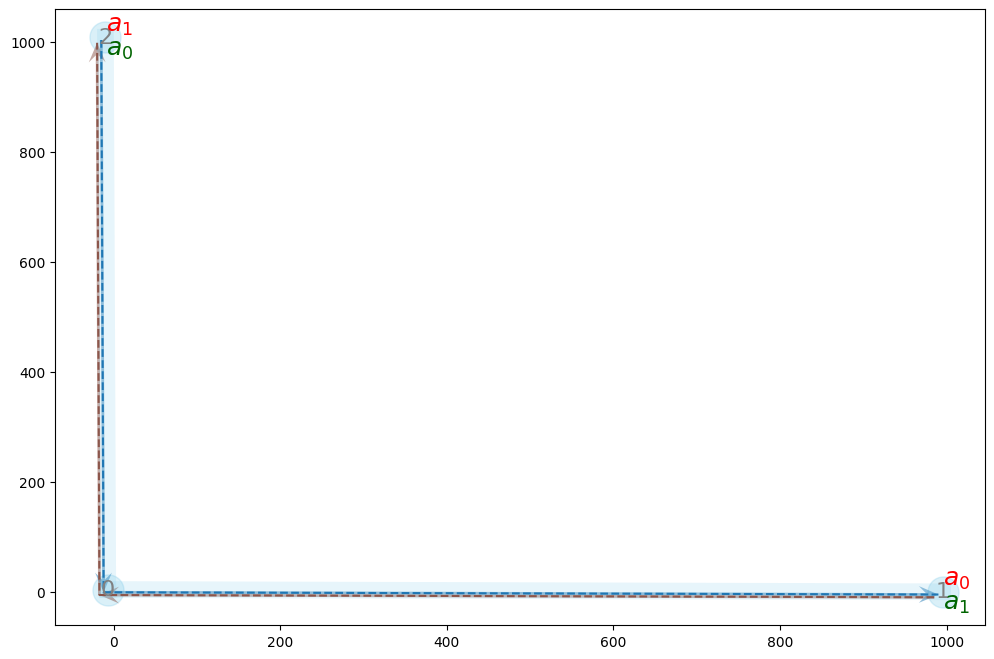

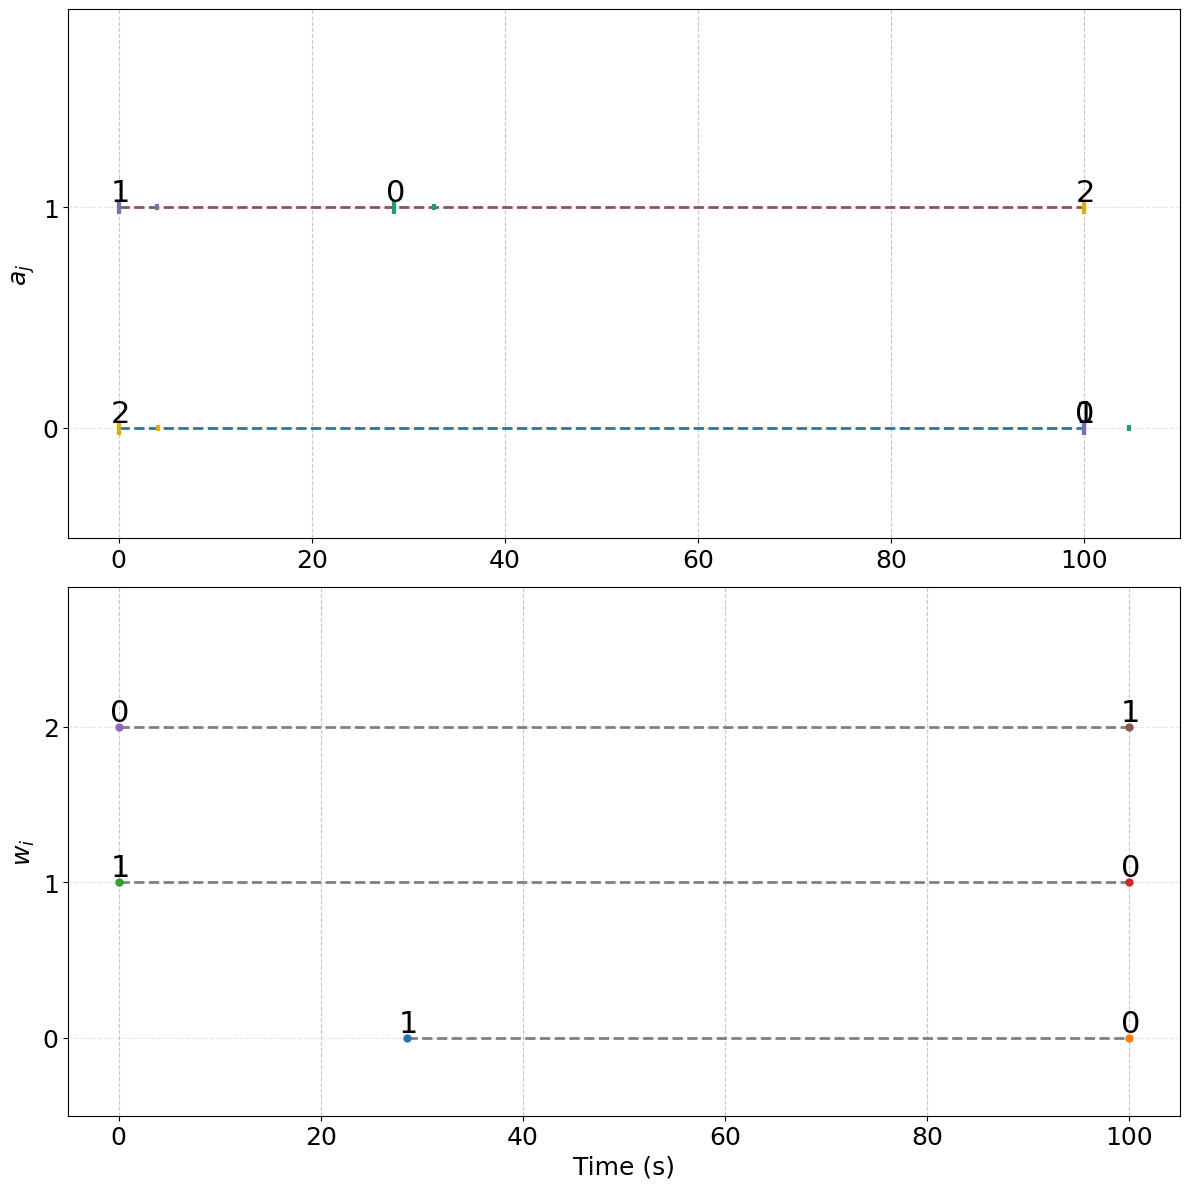

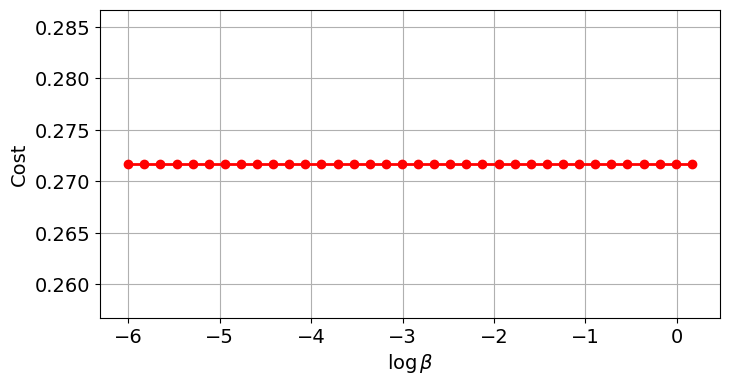

In [20]:
importlib.reload(createEnv)
importlib.reload(flpoAgent)
print('\nOptimization Results')
print(f'initial schedule:{sched_vec0}')
print(f'final schedule:\n{mars.sched_mat}')
print(f'processing time:\n{mars.process_T}')
print(f'cost:{C_arr[-1]}')

agent_routes, agent_schedules = createEnv.calc_agent_routes_and_schedules(mars, Pb_a, printRoutes=True)
createEnv.plotNetwork(mars=mars, figuresize=(12,8), routes=agent_routes, agent_colors=agent_colors, showEdgeLength=False, plotPaths=True)
# createEnv.plot_vehicle_routes(agent_routes, agent_schedules, mars.process_T, agent_colors)
# createEnv.plot_waypoint_schedules(filter_wp_beta_data[-1], mars.sched_mat)
createEnv.plot_waypoint_agent_schedules(
    agent_routes, agent_schedules, mars.sched_mat, 
    filter_wp_beta_data[-1], mars.process_T, agent_colors,
    figuresize=(12,12))
plt.figure(figsize=(8,4))
plt.plot(np.log(beta_arr)/np.log(10), conflict_C_arr.sum(axis=1), marker='o', linewidth=2, color='red')
plt.xlabel(rf'$\log\beta$', fontsize=14)
plt.ylabel(rf'Cost', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# plt.title(rf'Cumulative conflict management')
# plt.legend([rf"$w_{str(i)}$" for i in range(conflict_C_arr.shape[1])])
plt.grid()
plt.show()
# agent visualization
show_graph=0
if show_graph:
    for i,v in enumerate(mars.agents):
        v.showGraph(mars.wp_locations, mars.dist_mat, mars.mask, mars.sched_mat[i,:], figuresize=(10,5), showEdgeTimeLim=True)

# # show path associations
# Pb = mars.agents[0].getPathAssociations(mars.sched_mat[0,:], mars.dist_mat, beta_arr[-1], gamma_arr[-1][0], gamma_arr[-1][2])
# Xi = mars.agents[0].returnStageWiseCost(mars.sched_mat[5,:], mars.dist_mat, gamma_arr[-1][0], gamma_arr[-1][2])
# mars.agents[0].getFreeEnergy_s(mars.sched_mat[0,:], mars.dist_mat, beta=beta_arr[-1], gamma=gamma_arr[-1][0], coeff=gamma_arr[-1][2])
# print(f'freeEnergy: {mars.agents[0].freeEnergy_s}')
# print(f'path association:\n{Pb}')
# print(f'path costs:\n{Xi}')
# # test weighedLassoCost
# cost = createEnv.weighedLassoCost(mars, mars.sched_mat, beta=beta_arr[-1], gamma=beta_arr[-1], tol=1e-3)
